# Chapter 4: Tactical portfolio management

### 4.1. How dynamic methods works?
> ###### 4.1.1. Short a stock
> ###### 4.1.2. Momentum factor
> ###### 4.1.3. Rebalancing

### 4.2. Moving average strategy
> ###### 4.2.1. Moving average 
> ###### 4.2.2. Moving average factor
> ###### 4.2.3. Build the strategy

### 4.3. Correlation strategy
> ###### 4.3.1. Correlation
> ###### 4.3.2. Correlation factor
> ###### 4.3.3. Build the strategy

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('seaborn-v0_8')
import warnings
warnings.filterwarnings("ignore")

In [12]:
# Importation of data
list_tickers = ["META", "NFLX", "TSLA"]
database = yf.download(list_tickers)

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna()

[*********************100%%**********************]  3 of 3 completed


### 4.2.1. Moving average

In [13]:
# Create the SMA15 for the stocks
data["SMA15 META"] = data["META"].rolling(15).mean().shift(1)
data["SMA15 NFLX"] = data["NFLX"].rolling(15).mean().shift(1)
data["SMA15 TSLA"] = data["TSLA"].rolling(15).mean().shift(1)

# Create a SMA60
data["SMA60 META"] = data["META"].rolling(60).mean().shift(1)

# Plot the data
print(data)

Ticker            META        NFLX        TSLA  SMA15 META  SMA15 NFLX  \
Date                                                                     
2012-05-18   38.151600    9.994286    1.837333         NaN         NaN   
2012-05-21   33.960213   10.248571    1.918000         NaN         NaN   
2012-05-22   30.936428    9.672857    2.053333         NaN         NaN   
2012-05-23   31.934378   10.272857    2.068000         NaN         NaN   
2012-05-24   32.962265   10.038571    2.018667         NaN         NaN   
...                ...         ...         ...         ...         ...   
2024-07-01  504.679993  673.609985  209.860001  504.442967  667.480668   
2024-07-02  509.500000  679.580017  231.259995  505.256897  669.623336   
2024-07-03  509.959991  682.510010  246.389999  505.750130  671.962004   
2024-07-05  539.909973  690.650024  251.520004  505.949687  674.226005   
2024-07-08  529.320007  685.739990  252.940002  508.054665  676.932007   

Ticker      SMA15 TSLA  SMA60 META  


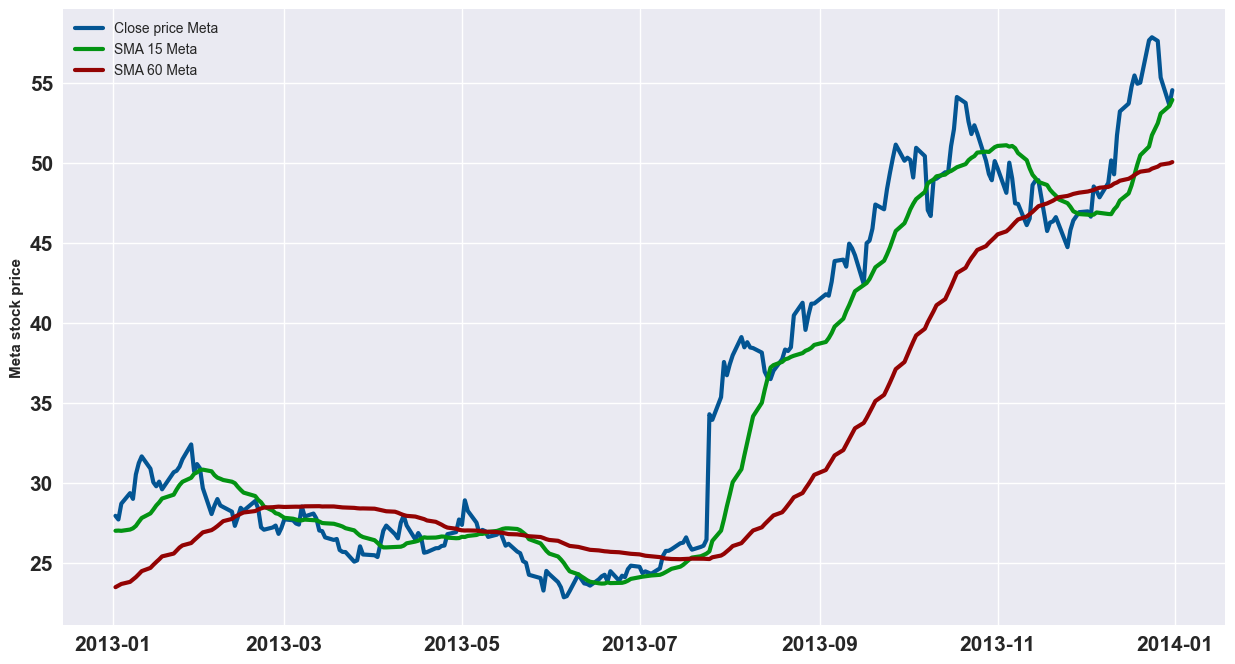

In [14]:
# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(data["META"].loc["2013"], color="#035593", linewidth=3)
plt.plot(data["SMA15 META"].loc["2013"], color="#039313", linewidth=3)
plt.plot(data["SMA60 META"].loc["2013"], color="#930303", linewidth=3)
plt.ylabel("Meta stock price",fontweight="bold")
plt.legend(["Close price Meta", "SMA 15 Meta", "SMA 60 Meta"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

<br>

### 4.2.2. Moving average factor

###### From this point the data are monthly and not daily

In [15]:
# We need monthly data now

# Importation of data
list_tickers = ["META", "NFLX", "TSLA"]
database = yf.download(list_tickers, interval="1mo")

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna()

# Display the data
data

[*********************100%%**********************]  3 of 3 completed


Ticker,META,NFLX,TSLA
Date,,,
2012-06-01,31.036222,9.784286,2.086000
2012-07-01,21.665478,8.121429,1.828000
2012-08-01,18.022963,8.531429,1.901333
2012-09-01,21.615582,7.777143,1.952000
2012-10-01,21.066710,11.320000,1.875333
...,...,...,...
2024-03-01,485.098358,607.330017,175.789993
2024-04-01,429.743347,550.640015,183.279999
2024-05-01,466.366943,641.619995,178.080002


In [16]:
# Create the all necessary SMA
list_tickers = ["META", "NFLX", "TSLA"]

# We do a loop to create the SMAs for each asset
for col in list_tickers:
    data[f"pct {col}"] = data[col].pct_change(1)
    data[f"SMA3 {col}"] = data[col].rolling(3).mean().shift(1)
    data[f"SMA12 {col}"] = data[col].rolling(12).mean().shift(1)
    data[f"Momentum factor {col}"] = data[f"SMA3 {col}"] - data[f"SMA12 {col}"]

# Normalizing the zscore
split = int(0.7*len(data))
train_set = data.iloc[:split,:]
test_set = data.iloc[split:,:]

# Find the mean and std vectors
columns = [f"Momentum factor {col}" for col in list_tickers]
train_set_mean = train_set[columns].mean()
train_set_std = train_set[columns].std()

# Create the zscores
train_set[columns] = (train_set[columns] - train_set_mean) / train_set_std
test_set[columns] = (test_set[columns] - train_set_mean) / train_set_std

# Find the medians
median = train_set[columns].median()

<br>

### 4.2.3. Build the strategy

In [17]:
# Compute the signals and the profits
for i in range(len(columns)):

    # Initialize a new column for the signal
    test_set[f"signal {columns[i]}"] = 0

    # Signal is -1 if factor < median
    test_set.loc[test_set[f"{columns[i]}"]<median[i], 
               f"signal {columns[i]}"] = -1

    # Signal is 1 if factor > median
    test_set.loc[test_set[f"{columns[i]}"]>median[i], 
               f"signal {columns[i]}"] = 1


    # Compute the profit
    test_set[f"profit {columns[i]}"] = (test_set[f"signal {columns[i]}"]\
          .shift(1)) * test_set[f"pct {list_tickers[i]}"]

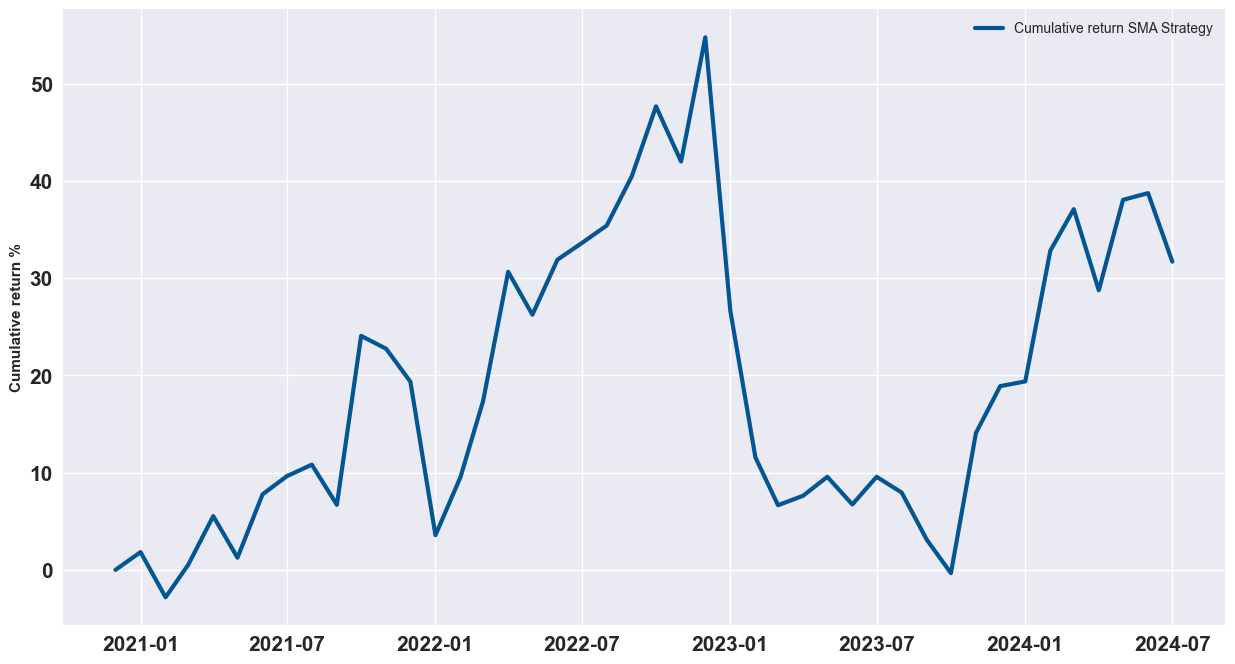

In [18]:
returns = test_set[[f"profit {columns[i]}" \
        for i in range(len(columns))]].sum(axis=1) .cumsum()*100/3

plt.figure(figsize=(15,8))
plt.plot(returns, color="#035593", linewidth=3)
plt.ylabel("Cumulative return %",fontweight="bold")
plt.legend(["Cumulative return SMA Strategy"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

In [19]:
# Code created in the chapter 5
from Backtest import *
pi = (test_set[[f"profit {columns[i]}" for i in range(len(columns))]].sum(axis=1)/3)
backtest_dynamic_portfolio(pi, timeframe=12)

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

<br>
<br>
<br>



### 4.3.1. Correlation

In [20]:
# Plot absolute price correlation
data[list_tickers].corr()

Ticker,META,NFLX,TSLA
Ticker,,,
META,1.000000,0.927325,0.705464
NFLX,0.927325,1.000000,0.716929
TSLA,0.705464,0.716929,1.000000


In [21]:
# Plot returns correlation
data[list_tickers].pct_change(1).corr()

Ticker,META,NFLX,TSLA
Ticker,,,
META,1.000000,0.283039,0.281223
NFLX,0.283039,1.000000,0.250374
TSLA,0.281223,0.250374,1.000000


<br>

### 4.3.2. Trend return factor

In [22]:
# Our stocks list
list_ = ["TSLA", "GOOG", "META", "NVDA", "PYPL", "CMCSA", "INTC", "NFLX"] 

In [23]:
# We need monthly data now

# Importation of data
database = yf.download(list_, interval="1mo")

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna()

#Display the data
data

[*********************100%%**********************]  8 of 8 completed


Ticker,CMCSA,GOOG,INTC,META,NFLX,NVDA,PYPL,TSLA
Date,,,,,,,,
2015-08-01,23.143530,30.877363,22.354168,89.246605,115.029999,0.544215,35.000000,16.604000
2015-09-01,23.369507,30.386421,23.803499,89.715645,103.260002,0.599259,31.040001,16.559999
2015-10-01,25.727818,35.500103,26.741421,101.760887,108.379997,0.689695,36.009998,13.795333
2015-11-01,25.111624,37.087795,27.460098,104.026230,123.330002,0.771136,35.259998,15.350667
2015-12-01,23.283749,37.900871,27.399040,104.445374,114.379997,0.804324,36.200001,16.000668
...,...,...,...,...,...,...,...,...
2024-03-01,42.682571,152.086929,43.991318,485.098358,607.330017,90.344337,66.989998,175.789993
2024-04-01,37.523251,164.452866,30.346739,429.743347,550.640015,86.394905,67.919998,183.279999
2024-05-01,39.704807,173.762268,30.725203,466.366943,641.619995,109.624001,62.990002,178.080002


In [24]:
# Compute the lookback and hold period
for col in list_:
    data[f"pct+1 {col}"] = data[f"{col}"].pct_change(-1)
    data[f"pct-12 {col}"] = data[f"{col}"].pct_change(12)

# Normalizing the zscore
split = int(0.7*len(data))
train_set = data.iloc[:split,:]
test_set = data.iloc[split:,:]


# Compute the correlation
corr = []
for col in list_:
    cor = train_set[[f"pct-12 {col}", f"pct+1 {col}"]].corr().values[0][1]

    corr.append(cor)

correlation = pd.DataFrame(corr, index=list_, columns=["Corr"])
correlation.sort_values(by="Corr", ascending=False)

,Corr
INTC,0.302611
CMCSA,0.171344
NFLX,0.148103
META,0.081507
PYPL,0.080745
GOOG,0.011936
TSLA,-0.067887
NVDA,-0.104026


<br>

### Build the strategy

In [25]:
best = ["PYPL", "INTC", "GOOG"]

# Find the mean and std vectors
columns = [f"pct-12 {col}" for col in best]
train_set_mean = train_set[columns].mean()
train_set_std = train_set[columns].std()

# Create the zscores
train_set[columns] = (train_set[columns] - train_set_mean) / train_set_std
test_set[columns] = (test_set[columns] - train_set_mean) / train_set_std

# Find the medians
median = train_set[columns].median()

# Compute the signals and the profits
for i in range(len(columns)):

    # Initialize a new column for the signal
    test_set[f"signal {columns[i]}"] = 0

    # Signal is -1 if factor < median
    test_set.loc[test_set[f"{columns[i]}"]<median[i], 
               f"signal {columns[i]}"] = -1

    # Signal is 1 if factor > median
    test_set.loc[test_set[f"{columns[i]}"]>median[i], 
               f"signal {columns[i]}"] = 1


    # Compute the profit
    test_set[f"profit {columns[i]}"] = (test_set[f"signal {columns[i]}"]\
          .shift(1)) * test_set[f"pct+1 {best[i]}"]

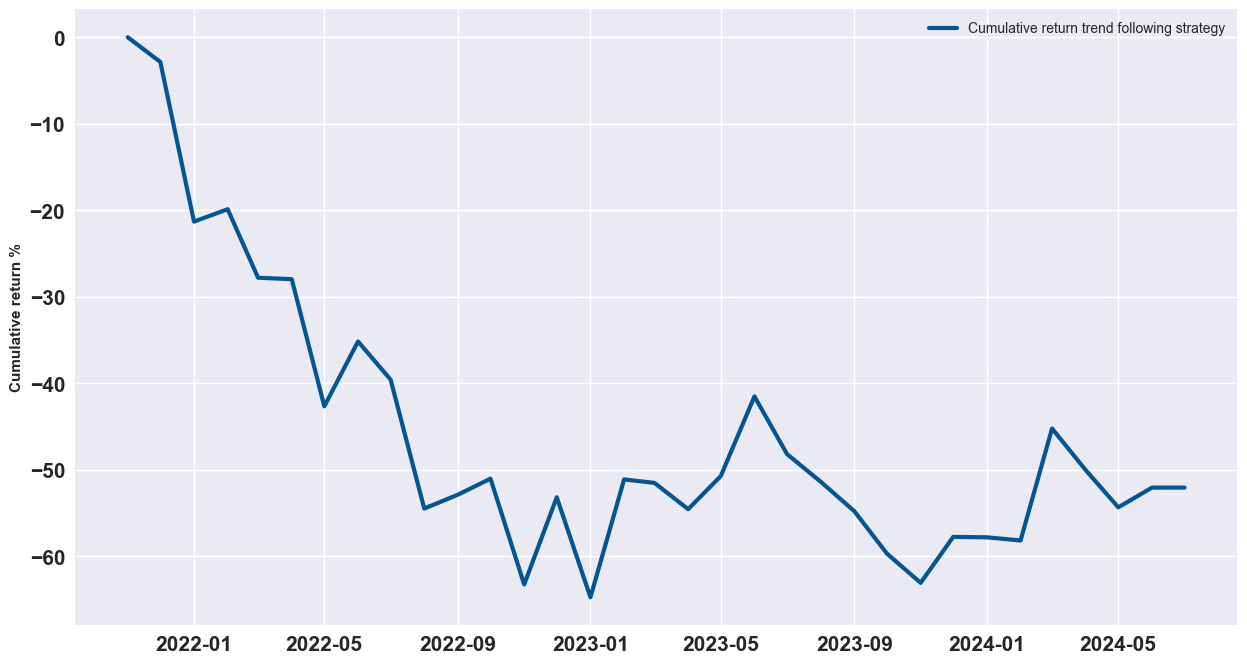

In [26]:
returns = test_set[[f"profit {columns[i]}" \
        for i in range(len(columns))]].sum(axis=1) .cumsum()*100/3

plt.figure(figsize=(15,8))
plt.plot(returns, color="#035593", linewidth=3)
plt.ylabel("Cumulative return %",fontweight="bold")
plt.legend(["Cumulative return trend following strategy"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

In [27]:
from Backtest import backtest_dynamic_portfolio
pi = (test_set[[f"profit {columns[i]}" for i in range(len(columns))]].sum(axis=1)/3)
backtest_dynamic_portfolio(pi, timeframe=12)

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)